# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Nicolás Rivera Guzmán

* __Rol__: 201510504-9

2.- Debes _pushear_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
    - Soluciones
    - Código
    - Que Binder esté bien configurado.
    - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from metrics_classification import summary_metrics
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from numpy import interp
from itertools import cycle
from sklearn.model_selection import validation_curve
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

# Objetivo
El objetivo es obtener el mejor modelo de clasificación, que reconozcan el numero en la imagen del conjunto de datos.

In [6]:
#Memoria usada por el conjunto de datos

print(f"{digits.memory_usage().sum()} bytes")

467348 bytes


In [7]:
#Distribucion de datos

digits.drop("target",axis=1).describe()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c54,c55,c56,c57,c58,c59,c60,c61,c62,c63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


# Tipo de datos

In [8]:
digits.dtypes

c00       int32
c01       int32
c02       int32
c03       int32
c04       int32
          ...  
c60       int32
c61       int32
c62       int32
c63       int32
target    int32
Length: 65, dtype: object

Los tipos de variables que tiene el conjunto de datos son:

 - Categóricas: target.

 - Numéricas: c00 - c63
 
*Nota: La columna target indica el numero al que corresponde la imagen, por lo que se considera categorica

# Resumen de datos

In [9]:
#funcion para resumir cada columna

def resumen_por_columna(df,cols):
    pd_series = df[cols]
    
    # elementos distintos 
    l_unique = pd_series.unique()
    
    # elementos vacios
    
    l_vacios = pd_series[pd_series.isna()]
    
    df_info = pd.DataFrame({
        'columna': [cols],
        'unicos': [len(l_unique)],
        'vacios': [len(l_vacios)]
    })
    
    return df_info

In [10]:
#Resumen de columnas

frames = []

for col in digits.columns:
    aux_df = resumen_por_columna(digits,col)# Se agrega la info de cada columna
    frames.append(aux_df) 
    
df_info = pd.concat(frames).reset_index(drop=True) #Transformacion a dataframe
df_info['% vacios'] = df_info['vacios']/len(digits)

#resumen
display(df_info)
display(df_info.describe())

,columna,unicos,vacios,% vacios
0,c00,1,0,0.0
1,c01,9,0,0.0
2,c02,17,0,0.0
3,c03,17,0,0.0
4,c04,17,0,0.0
...,...,...,...,...
60,c60,17,0,0.0
61,c61,17,0,0.0
62,c62,17,0,0.0
63,c63,17,0,0.0


,unicos,vacios,% vacios
count,65.000000,65.0,65.0
mean,13.846154,0.0,0.0
std,5.449285,0.0,0.0
min,1.000000,0.0,0.0
25%,13.000000,0.0,0.0
50%,17.000000,0.0,0.0
75%,17.000000,0.0,0.0
max,17.000000,0.0,0.0


Ninguna columna tiene datos vacios.

In [11]:
#registros por clase
print(f"Hay {digits.shape[0]} registros por clase")

Hay 1797 registros por clase


Todos los registros corresponden a valores numericos.

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [12]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

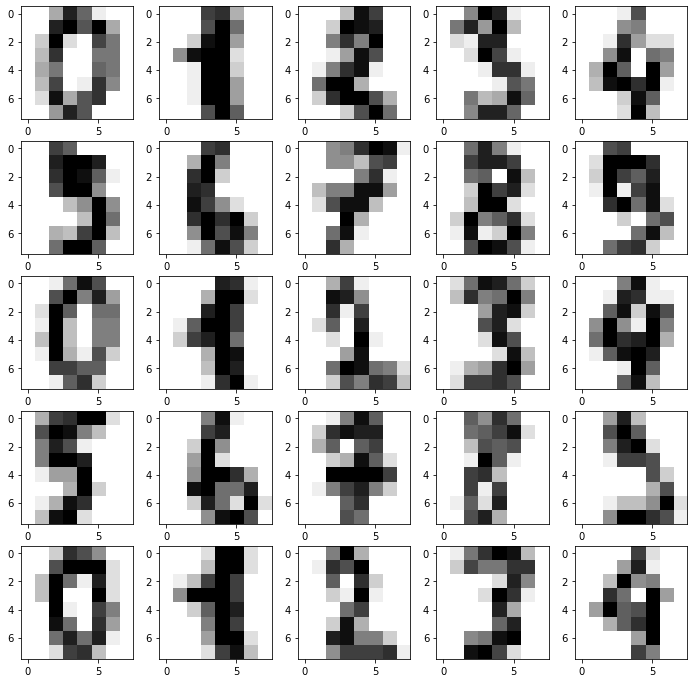

In [13]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))#Config. de subplots

j=0
for i in axs:
    for k in i:
        k.imshow(digits_dict["images"][j],cmap='gray_r')#Subplots
        j+=1


### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [14]:
X = digits.drop(columns="target").values
y = digits["target"].values

In [15]:
#rescale


scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

#train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 666)

In [16]:
# Tamaños de los sets train-test
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

numero de filas data original :  1797
numero de filas train set     :  1437
numero de filas test set      :  360


# Modelos a Usar
 - Regresión logística
 - K-Nearest Neighbours
 - SVM

In [17]:
#Regresión logística





#Grid para buscar hyperparametros
param_grid = [
    {"penalty" : ["l2", "none"]},
    {"C" : [1,2,3,4,5,6,7,8,9,10,20,30]},
    {"max_iter" : [10,50,100,200]}
]
  
   
#Ajuste de modelo
logr = LogisticRegression()
grd_srch = GridSearchCV(logr, param_grid)
grd_srch.fit(X_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'penalty': ['l2', 'none']},
                         {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]},
                         {'max_iter': [10, 50, 100, 200]}])

In [18]:
#parametro encontrado
grd_srch.best_params_

{'C': 4}

In [19]:
#score del mejor parametro
grd_srch.score(X_train,y_train)

0.9972164231036882

[[38  0  0  0  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0  1  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 40  0  1  0  0  3  0]
 [ 0  0  0  0 42  0  0  0  0  0]
 [ 0  0  0  0  0 29  0  0  0  1]
 [ 0  0  0  0  0  1 29  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  2 37  0]
 [ 0  0  0  0  0  0  0  0  1 35]]


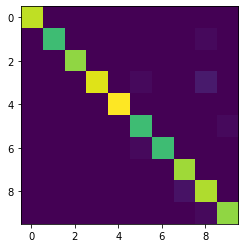

In [20]:
#metricas



y_true =  list(y_test)
y_pred = list(grd_srch.predict(X_test))

#matriz de confusion
print(confusion_matrix(y_true,y_pred))

plt.imshow(confusion_matrix(y_true,y_pred))
plt.show()

In [21]:
#accuracy recall precision fscore


df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics1 = summary_metrics(df_temp)
df_metrics1

,accuracy,recall,precision,fscore
0,0.9722,0.973,0.9736,0.9728


In [22]:
#K-Nearest Neighbours



#Grid para buscar hyperparametro
param_grid = [
  {'n_neighbors': [1, 5, 10, 50, 100, 500, 1000]}
]
   
#ajuste de modelo
kne = KNeighborsClassifier()
grd_srch = GridSearchCV(kne, param_grid)
grd_srch.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 5, 10, 50, 100, 500, 1000]}])

In [23]:
#mejor parametro
grd_srch.best_params_

{'n_neighbors': 1}

In [24]:
#score del mejor parametro
grd_srch.score(X_train,y_train)

1.0

[[38  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 44  0  0  0  0  0  0]
 [ 0  0  0  0 42  0  0  0  0  0]
 [ 0  0  0  0  0 29  0  0  0  1]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0 38  1]
 [ 0  0  0  1  0  1  0  0  1 33]]


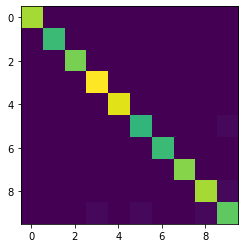

In [25]:
#metricas

y_true =  list(y_test)
y_pred = list(grd_srch.predict(X_test))

#matriz de confusion
print(confusion_matrix(y_true,y_pred))

plt.imshow(confusion_matrix(y_true,y_pred))
plt.show()

In [26]:
#accuracy recall precision fscore
df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics2 = summary_metrics(df_temp)
df_metrics2

,accuracy,recall,precision,fscore
0,0.9861,0.9858,0.9862,0.9859


In [27]:
#SVM


param_grid = [
    {"C": [1,2,3,4,5,10,20]},
    {"gamma": ["scale","auto"]}
]

svc = SVC()
grd_srch = GridSearchCV(svc, param_grid)
grd_srch.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 2, 3, 4, 5, 10, 20]},
                         {'gamma': ['scale', 'auto']}])

In [28]:
#mejor parametro
grd_srch.best_params_

{'C': 4}

In [29]:
#score del mejor parametro
grd_srch.score(X_train,y_train)

1.0

[[38  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 43  0  1  0  0  0  0]
 [ 0  0  0  0 42  0  0  0  0  0]
 [ 0  0  0  0  0 29  0  0  0  1]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0 39  0]
 [ 0  0  0  1  0  0  0  0  0 35]]


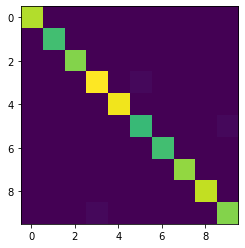

In [30]:
#metricas

y_true =  list(y_test)
y_pred = list(grd_srch.predict(X_test))


#matriz de confusion
print(confusion_matrix(y_true,y_pred))

plt.imshow(confusion_matrix(y_true,y_pred))
plt.show()

In [31]:
#accuracy recall precision fscore
df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics3 = summary_metrics(df_temp)
df_metrics3

,accuracy,recall,precision,fscore
0,0.9917,0.9916,0.9916,0.9916


In [32]:
#mejor modelo

comp= pd.concat([df_metrics1,df_metrics2,df_metrics3])
comp["model"] = ["log_reg","k_nei","SVC"]
comp

,accuracy,recall,precision,fscore,model
0,0.9722,0.9730,0.9736,0.9728,log_reg
0,0.9861,0.9858,0.9862,0.9859,k_nei
0,0.9917,0.9916,0.9916,0.9916,SVC


Se puede apreciar que para todas las metricas, el modelo SVC tiene mejor desempeño.

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

In [33]:
#CV

grd_srch = GridSearchCV(svc, param_grid)#modelo SVC
scores = cross_val_score(grd_srch, X_test, y_test, cv=10)#cv
scores

array([1.        , 0.97222222, 0.94444444, 1.        , 0.97222222,
       1.        , 1.        , 0.97222222, 0.97222222, 1.        ])

In [34]:
print(f"score: {scores.mean()} ± {scores.std()}")

score: 0.9833333333333334 ± 0.018425693279752228


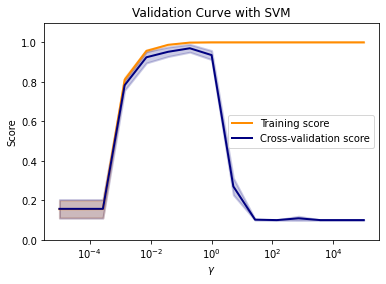

In [35]:
#Validation curve



param_range = np.logspace(-5, 5, 15)
train_scores, test_scores = validation_curve(
    SVC(),
    X,
    y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=1,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

Se puede apreciar que para valores de gamma entre 10^-2 y 1 se gana precision tanto para el set de training como para el de cross-validation. Para valores mayores a 1 se pierde precision en el set de cross-validation

In [36]:
#Curva AUC–ROC


random_state = np.random.RandomState(0)

# Convertir el target a bianrio
y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])
n_classes = y_bin.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.5, random_state=0)


# Ajuste de modelo uno contra todos
classifier = OneVsRestClassifier(
    SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Curva y area ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average ya area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

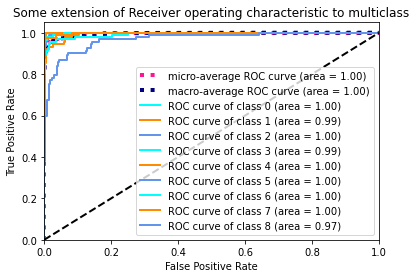

In [37]:
# Agregar falsos positivos
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolar las curvas ROC
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Promedio y computacion de AOC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot de las ROC
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()


### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [38]:
#Extracción de atributos


#tsne
embedding = TSNE(n_components=3)
X_transform = embedding.fit_transform(X)
    
df_tsne = pd.DataFrame(X_transform,columns = ['_DIM_1_','_DIM_2_','_DIM_3_'])
df_tsne["target"] = y

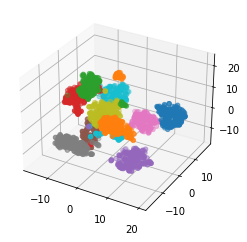

In [39]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for s in df_tsne.target.unique():
    ax.scatter(
        df_tsne._DIM_1_[df_tsne.target==s],
        df_tsne._DIM_2_[df_tsne.target==s],
        df_tsne._DIM_3_[df_tsne.target==s],
        label=s
    )
    
plt.show()

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [40]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    Y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == Y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != Y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    
    X_aux = X_test[mask]
    y_aux_true = Y_test[mask]
    y_aux_pred = np.array(y_pred)[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            if index >= X_aux.shape[0]:
                break
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

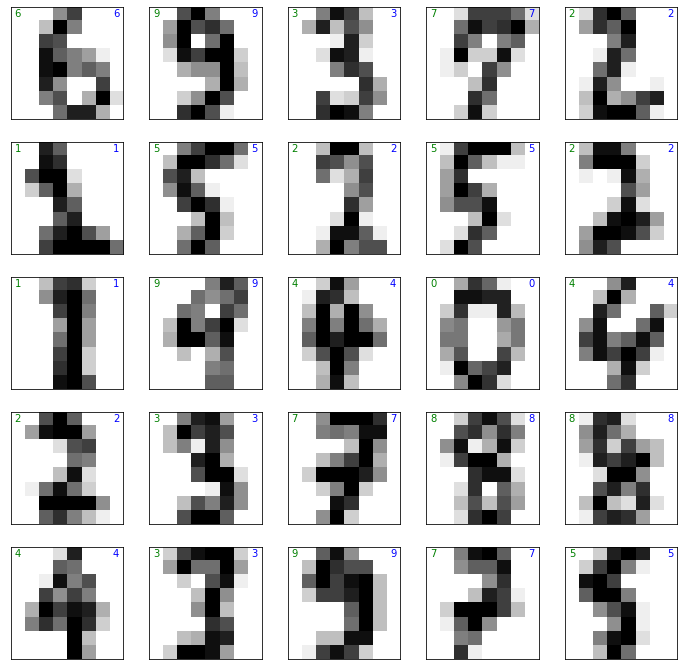

In [41]:
mostar_resultados(digits,grd_srch,nx=5, ny=5,label = "correctos")

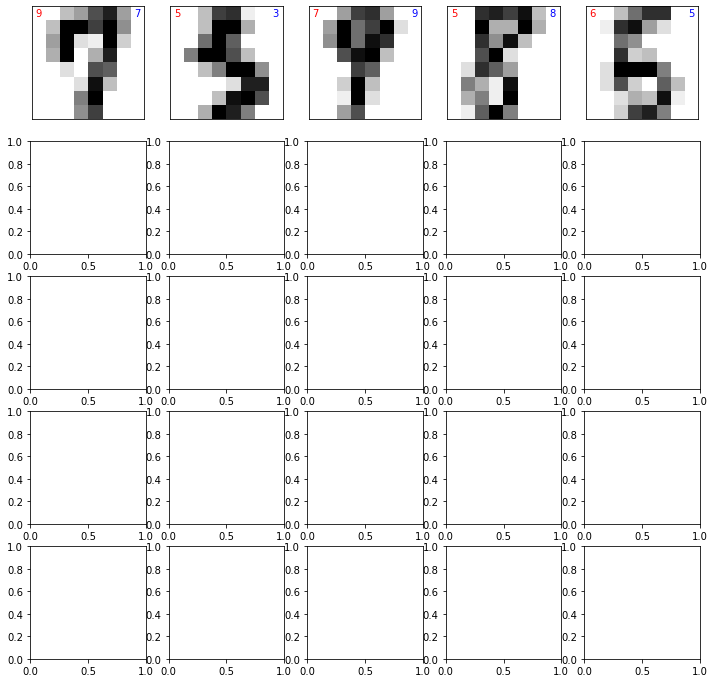

In [42]:
mostar_resultados(digits,grd_srch,nx=5, ny=5,label = "incorrectos")

Se puede ver que para los resultados incorrectos, la mayoria son por que las imagenes son ambiguas con respecto al numero que representan.

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

El de los tres modelos utiliados, el SVC fue el que tuvo mejor desempeño, con un score de aproximadamente 0.98 ± 0.02. Se obtuvo que los mejores de los hiperparametros para obtener un buen modelo, sin caer en overfitting para C y gamma, son 4 y 10^-. Las dificultades que tiene el metodo se encuentran en imagenes similares a numeros que no son los que representan.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [43]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [44]:
housing.shape

(20640, 10)

Se separan las variables numericas de las categoricas

In [45]:
# Resumen de la informacion

print(housing.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [46]:
207/20640*100

1.002906976744186

Como hay al rededor de un 1% de datos faltantes para la variable total_bedrooms, se opta por eliminar los datos faltantes.

In [47]:
housing = housing.dropna()

In [48]:
#separar variables numericas de las categoricas

housing_num = housing.select_dtypes(include=[np.number])
num_cols = housing_num.columns.values

housing_cat = housing.select_dtypes(exclude=[np.number])
cat_cols = housing_cat.columns.values
print(f"var. numericas: {num_cols}\n")
print(f"var. categoricas: {cat_cols}")

var. numericas: ['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income'
 'median_house_value']

var. categoricas: ['ocean_proximity']


In [49]:
#Revision de variable categorica
housing_cat['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

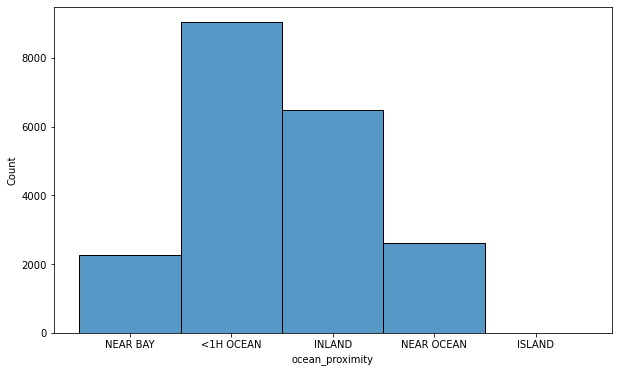

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(housing_cat.ocean_proximity)
plt.show()

In [51]:
mask = housing_cat.ocean_proximity == "ISLAND"
housing[mask].shape

(5, 10)

Si bien los datos de casas en islas son pocos, no se pueden ignorar, ya que el hecho de que una casa este en una isla puede afectar su valor.

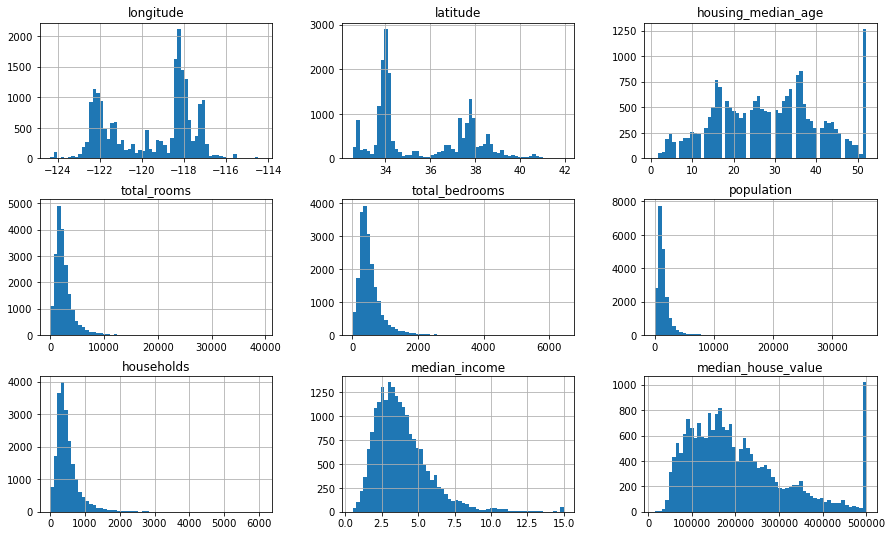

In [52]:
#Revision de datos numericos

housing.hist(bins=60, figsize=(15,9));plt.show()

Si bien, para algunas columnas hay datos que estan bastante alejados en la distribucion, es una cantidad menor, a excepcion de las columnas housing_median_age y median_house_value, lo que indica que pueden ser outliers o a que se asignó un valor tope

In [53]:
housing_num["housing_median_age"].describe()

count    20433.000000
mean        28.633094
std         12.591805
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64

No se puede concluir mucho sobre este dato.

In [54]:
housing_num["median_house_value"].describe()

count     20433.000000
mean     206864.413155
std      115435.667099
min       14999.000000
25%      119500.000000
50%      179700.000000
75%      264700.000000
max      500001.000000
Name: median_house_value, dtype: float64

En este caso, como el valor irregular esta en la variable de interes, esto puede provocar problemas al momento de aplicar el modelo, por lo que se eliminará, 

In [55]:
housing = housing[housing['median_house_value'] != 500001]

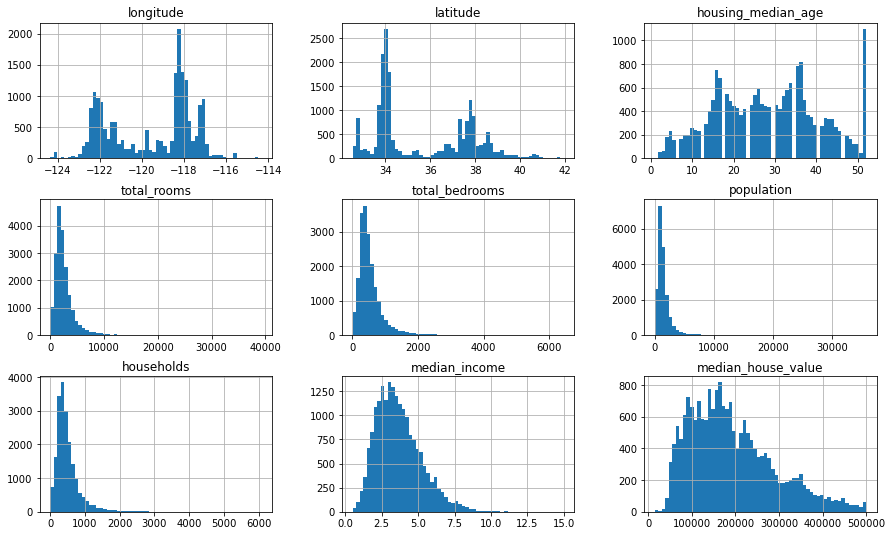

In [56]:
housing.hist(bins=60, figsize=(15,9));plt.show()

Se puede apreciar que hay muchos datos sesgados, lo que puede dificultar la regresión

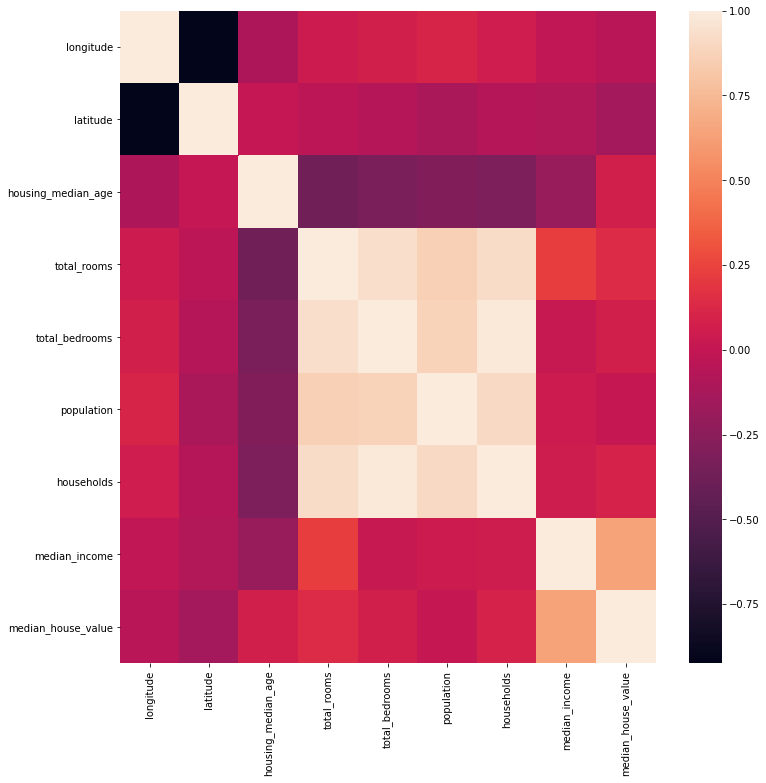

In [57]:
#Mapa de calor de la matriz de correlacion

corr = housing.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

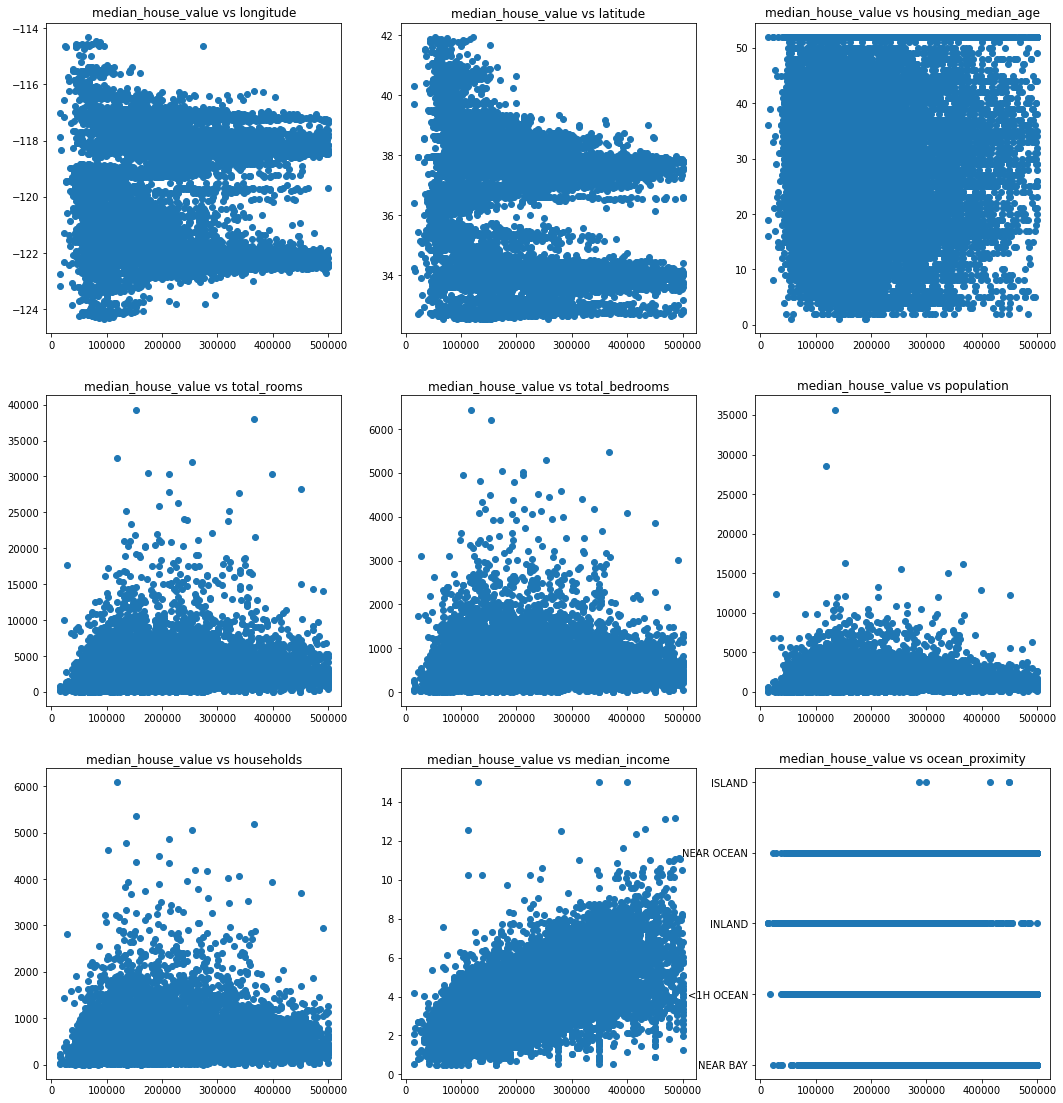

In [58]:
# Scatter plot entre la variable objetivo y el resto.
plt.figure(figsize=(18,40))

j=1
for columna in housing.columns:
    if columna!='median_house_value':
        plt.subplot(6,3,j)
        plt.scatter(housing['median_house_value'], housing[columna])
        plt.title("median_house_value vs "+str(columna))
        j+=1
plt.show()

Se puede ver que para algunas variables hay algo de correlación, como con la columna median_income. mientras que con otras como housing_median_age o la latitud y la longitud, no hay ninguna.

Se intentara combinar linealmente estas ultimas para ver si hay alguna relacion con las coordenadas diagonales.


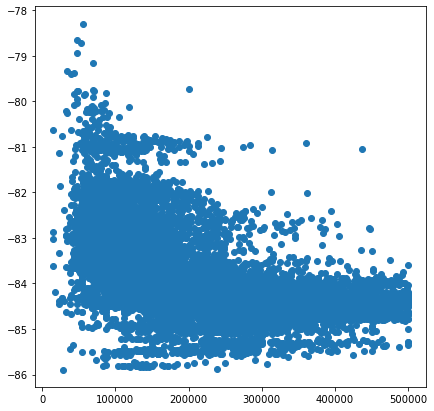

In [59]:
#diagonal hacia el nor-este
plt.figure(figsize=(7,7))
plt.scatter(housing["median_house_value"], housing["longitude"] + housing["latitude"])
plt.show()

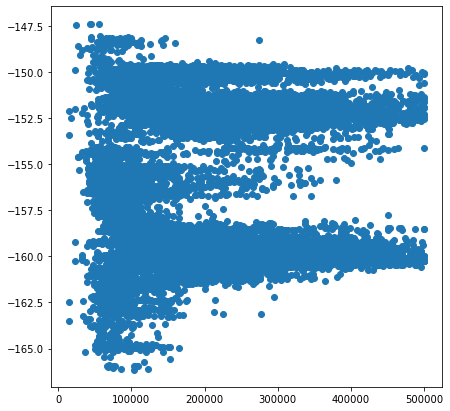

In [60]:
#diagonal hacia el sur-este
plt.figure(figsize=(7,7))
plt.scatter(housing["median_house_value"], housing["longitude"] - housing["latitude"])
plt.show()

Se ve que hay alguna relación entre la diagonal nor-este y el precio por lo que considerará usar estos datos en la regresion.

In [61]:
housing_updt = housing.drop(["housing_median_age","latitude","longitude","ocean_proximity"],axis=1)
housing_updt["diag"] = (housing["longitude"] + housing["latitude"])

Tambien dada la alta correlación entre las columnas population, households, total_bedrooms y total_rooms, seria redundante usar las cuatro, por lo que se considerará una de ellas.

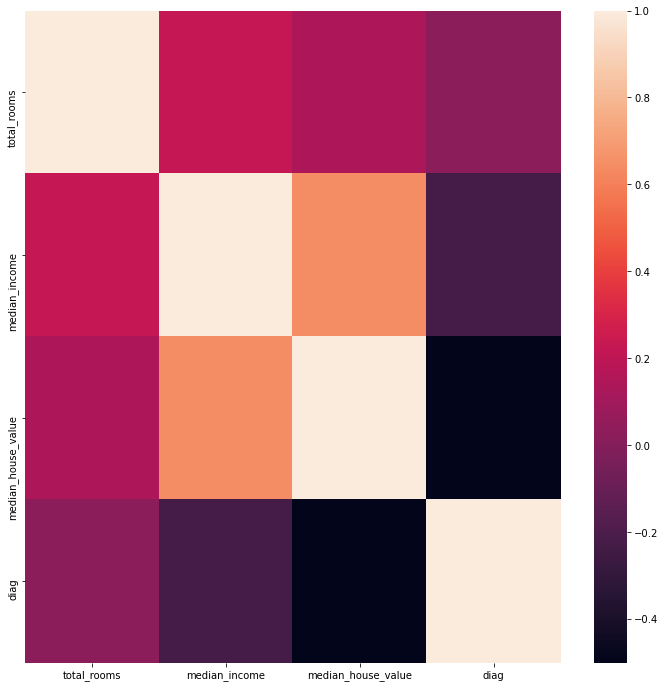

In [62]:
housing_updt = housing_updt.drop(["population","households","total_bedrooms"],axis=1)

corr = housing_updt.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

# Modelos

## Lasso

In [63]:
#definir datos de regresion
y = np.asarray(housing_updt["median_house_value"])
X= np.asarray(housing_updt.drop("median_house_value",axis=1))
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [64]:
# definir modelo y grid para optimizar el hiperparametro
model = Lasso()
l_grid = {'alpha':[0,0.01,0.1,0.2,0.3,0.4,1,2,3,4,5,10,15,20,30]}
lasso = GridSearchCV(model, l_grid)

#ajustar modelo
lasso.fit(X_train, y_train)

#resumen
print('MAE: %.3f' % lasso.best_score_)
print('Config: %s' % lasso.best_params_)

MAE: 0.543
Config: {'alpha': 15}


In [65]:
print(f"score de el ajuste: {lasso.score(X_test,y_test)}")

score de el ajuste: 0.5585376210560441


## Regresion Bayesiana

In [66]:
#modelo y grid
model = BayesianRidge()
bay_grid={'alpha_1':[0.1,0.2,0.3,0.4,1,2,5],
            'alpha_2':[0.1,0.2,0.3,0.4,1,2,5],
            'lambda_1':[0.1,0.2,0.3,0.4,1,2,5],
            'lambda_2':[0.1,0.2,0.3,0.4,1,2,5]}
bay_reg = GridSearchCV(model,bay_grid)

#ajuste
bay_reg.fit(X_train, y_train)

#resumen
print('MAE: %.3f' % bay_reg.best_score_)
print('Config: %s' % bay_reg.best_params_)

MAE: 0.543
Config: {'alpha_1': 0.1, 'alpha_2': 0.2, 'lambda_1': 0.3, 'lambda_2': 5}


In [67]:
print(f"score de el ajuste: {bay_reg.score(X_test,y_test)}")

score de el ajuste: 0.5585379692495767


## Arbol de desición

In [68]:
#modelo y grid
model = DecisionTreeRegressor()
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
d_tree = GridSearchCV(model,tree_para)

#ajuste
d_tree.fit(X_train, y_train)

#resumen
print('MAE: %.3f' % d_tree.best_score_)
print('Config: %s' % d_tree.best_params_)

MAE: 0.601
Config: {'max_depth': 7}


In [69]:
print(f"score de el ajuste: {d_tree.score(X_test,y_test)}")

score de el ajuste: 0.617693741704648


## Ridge

In [70]:
#modelo y grid
model = Ridge()
r_grid = {'alpha':[0,0.01,0.1,0.2,0.3,0.4,1,2,3,4,5,10,15,20,30]}
ridge = GridSearchCV(model,r_grid)

#ajuste
ridge.fit(X_train, y_train)

#resumen
print('MAE: %.3f' % ridge.best_score_)
print('Config: %s' % ridge.best_params_)

MAE: 0.543
Config: {'alpha': 10}


In [71]:
print(f"score de el ajuste: {ridge.score(X_test,y_test)}")

score de el ajuste: 0.5585397579656334


El mejor score es el de el modelo de arbol de desiciones.

## Visualización 

In [72]:
y_pred = d_tree.predict(X_test)

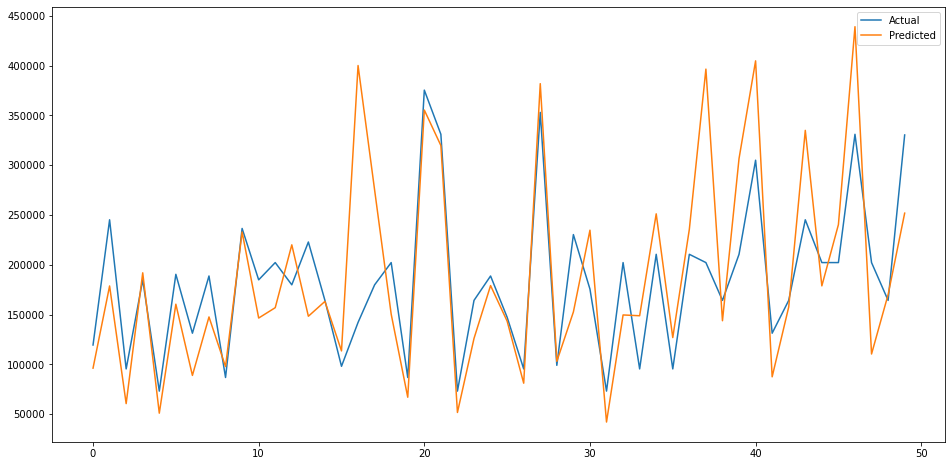

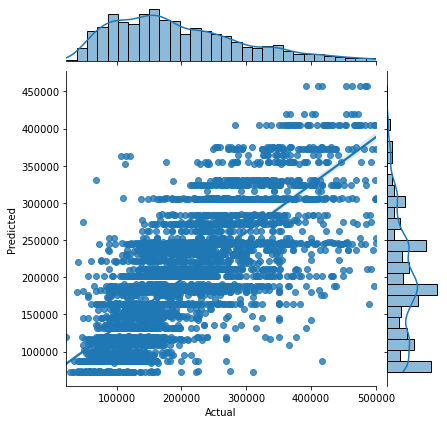

In [74]:
#plot de comparacion de datos

test = pd.DataFrame({'Predicted':y_pred,'Actual':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")
plt.show()

## Conclusiones

Como se pudo ver hay una gran cantidad de datos sesgados, lo que dificulta encontrar modelos de regresión por lo que se concluye que el set de datos es imbalanceado.